# 206.1. Deblender Outputs

<div>
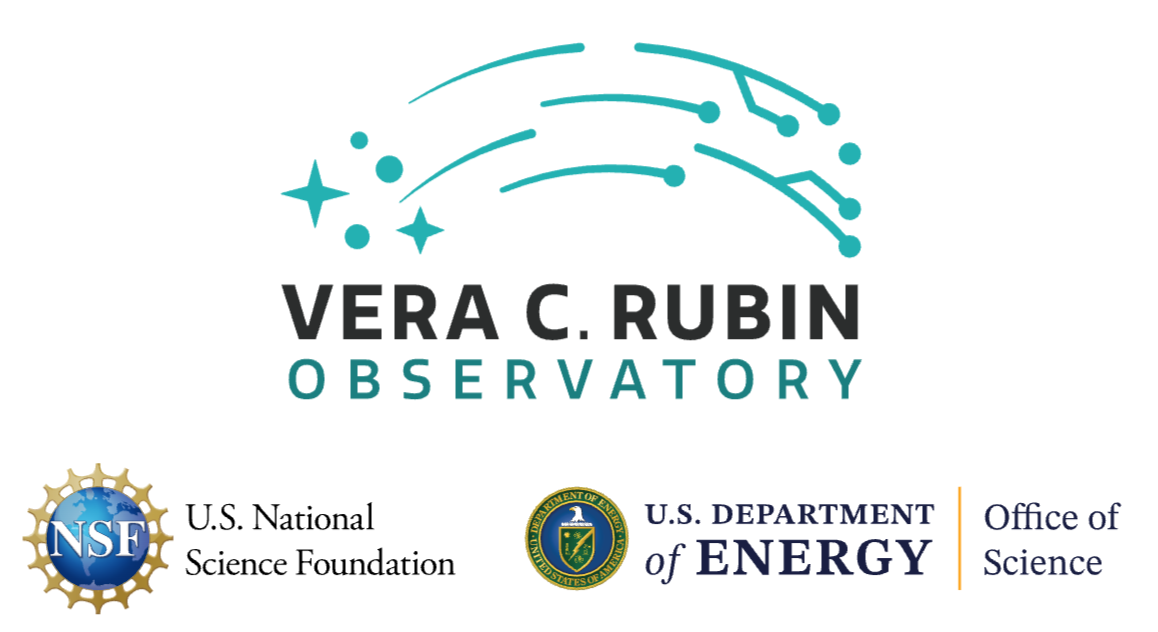
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP1 <br>
Container Size: Large <br>
LSST Science Pipelines version: Weekly v29.2.1 <br>
Last verified to run: 2025-09-10 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** This notebook demonstrates the meaning and basic use of deblender data products cataloged in the `objectTable`.

**LSST data products:** `objectTable`, `deep_coadd`

**Packages:** _List the python packages that are relevant to the learning objective. E.g., include afwDisplay and lsst.daf.butler for a notebook about retrieving and displaying images. E.g., standard supporting packages like os, glob, or numpy usually don't need to be listed here._

**Credit:**
Originally developed by Christina Williams and the Rubin Community Science team. This notebook is partly based on DP0.2 notebook 10 on deblender data products, and benefitted from helpful discussions with Fred Moolekamp. The deblender packages are based on <a href="https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract">Melchior et al. 2018</a>, and the <a href="https://pmelchior.github.io/scarlet/">Scarlet software</a> written by Peter Melchior and Fred Moolekamp. Further documentation on Scarlet is available at that site.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

### NOTES 
First notebook in series:
Key columns (not all). key concepts. how to know if a particular object was deblended. how to find a sample of things that didn't have to be deblended (isolated). visualization i already have is fine for a first notebook. 




## 1. Introduction

This notebook is an introduction to the data products in the `objectTable` that are associated with the deblending process.

In order to build its source catalog and measure photometry of objects in images, the LSST Science Pipeline uses the multi-wavelength deblending algorithm Scarlet (<a href="https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract">Melchior et al. 2018</a>) to identify independent detected components within source blends and separate the flux from independent objects.

A "**parent**" source is identified as a region of connected pixels above a given signal-to-noise ratio (S/N) in the `deepCoadd` image.
These regions are called footprints.
Each footprint may have one or more peaks, and it is these peaks that the deblender will use to infer the number and positions of objects blended in each footprint.
The deblended sub-peaks are referred to as "**children**" of the parent in the properties saved by the deblender in the `Object` table.

The Scarlet deblender separates the flux among components by modeling the flux and shape of each source making up the blend.

This tutorial will identify a heavily blended parent object with many children and explore how to interpret the deblender-related measurements in the `Object` table.
It will also demonstrate how to use deblender-related columns in the `Object` table to identify unique deblended child sources, and
provide an example of how to access metadata that is available for each deblended source (e.g. the deblended footprints and pixel-weight maps).

Additional resources

An introduction to all of the available deblending flags, and the processes that produce the deblender data products discussed in this tutorial
can be found in this <a href="https://pipelines.lsst.io/modules/lsst.pipe.tasks/deblending-flags-overview.html">overview of the deblending flags</a>.

A general discussion of blending impacts to LSST can be found in this article titled "<a href="https://lss.fnal.gov/archive/2021/pub/fermilab-pub-21-598-ppd.pdf">The challenge of blending in large sky surveys</a>" by Melchior et al. 2021. 

Some more in-depth presentations on the deblending implementation in the LSST Science Pipelines are available from recorded talks during the Rubin Project and Community Workshop 2022's session on "<a href="https://project.lsst.org/meetings/rubin2022/agenda/deblending-plans-and-challenges">Deblending Plans and Challenges</a>". 

### 1.1. Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` and `lsst.afw.detection` packages provide access to some of the extended products created by the deblender pipeline. 

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler

from lsst.rsp import get_tap_service
import lsst.geom as geom
import lsst.afw.display as afwDisplay
from lsst.afw.image import MaskedImage

import lsst.scarlet.lite as sl

### 1.2. Define functions and parameters

The following two functions enable the visualization of deblended products:
 1. `cutout_coadd` will make an image cutout (see DP0.2 tutorial notebook 03a on image display).
    
Define parameters to use colorblind-friendly colors with `matplotlib`.

In [2]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    query = """band.name = '{}' AND patch.region OVERLAPS POINT({}, {})
        """.format('i', ra, dec)
    print(query)

    dataset_refs = butler.query_datasets("deep_coadd", where=query)
    
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    # YOU CHANGED INDEX 0 TO INDEX 1 THIS DOENS"T ALWAYS WORK
    cutout_image = butler.get(dataset_refs[0], parameters=parameters)

    return cutout_image

In [3]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Set the backend for afwDisplay to matplotlib.

In [4]:
# multi- color linestyle definitions were here

afwDisplay.setDefaultBackend('matplotlib')

Get an instance of the TAP service, and assert that it exists.

In [5]:
service = get_tap_service("tap")
assert service is not None

Instantiate the butler.

In [6]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

## 2. The deblender data products

The object catalog contains a number of columns that can be used to identify and characterize blended sources (parents) that have been deblended into child sources. Only the children that are deblended from the parent are ultimately stored in the catalogs; the parents are excluded. Of course, isolated single sources that do not require deblending are also stored and are not considered parent sources.

In this tutorial we will focus on deblending data products for objects stored in the `objectTable`, which are detected and measured in the `deepCoadd` images.

The following describes a few of the key
boolean flags that are set by the deblender, and some measurements or properties of deblended sources that can be used to characterize (de)blended sources.


Blend flags:

`detect_fromBlend` (boolean): If True, this source is deblended from a parent with more than one child.

`detect_isIsolated` (boolean): If True, this source was not part of a blend. 


Blend measurements:

`parentObjectId` (long): Unique ID of parent source. 

`footprintArea` (int): Number of pixels in the deblended source's detection "footprint", in the "reference band".

`<f>_blendedness` (dbl): For each filter (f = u, g, r, i, z, or y), a measure of how much the flux is affected by neighbors, (1 - child\_flux/parent\_flux). Operates on the absolute value of the pixels to try to obtain a de-noised value.
See section 4.9.11 of <a href="https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract">Bosch et al. 2018, PASJ, 70, S5</a> for details.

This actually has nothing to do with the deblender... it comes from some old 

`<f>_deblend_blendedness` (dbl): Blendedness in filter <f> in the deconvolved scarlet space.

NOT KEY: `<f>_deblend_dataCoverage` (dbl): Fraction of data that contained good data, i.e. 1 - number of no data pixels/total number of pixels (in the <f>-band).

`<f>_deblend_fluxOverlap` (dbl): The total flux from neighboring objects that overlaps with this sources footprint in the deconvolved space. See also `<f>_deblend_fluxOverlapFraction` Fraction of flux from neighbors / source flux in the deconvolved footprint.

Failure flags:

`<f>_blendedness_flag` (boolean): Flag set for any failure in the blendedness algorithm. NOTE NOT THE DEBLENDER

`deblend_failed` (boolean): Deblender failed to deblend this source

NOT KEY: `deblend_incompleteData`: One or more bands were not deblended due to an inability to model the PSF.

`deblend_parentTooBig` (boolean): Deblender skipped this source because the parent footprint was too large.

`deblend_skipped` (boolean): If True, the deblender skipped this source and did not attempt to deblend.

`deblend_masked`: Deblender skipped this source because there were too many masked pixels.

These columns are artifacts from a time when the parents were included in the same catalog.Some of the columns from DP0.2 have now been deprecated, although still appear in the objectTable. This includes `deblend_nChild`, which is present but does not contain useful information because in DP1 because the parent blends themselves are now excluded from the objectTable. Similarly, `deblend_nPeaks`, which used to contain the number of peaks a parent object has in DP0.2, still appears in DP1, but always contains the value 1 because only child objects are in the objectTable. These columns are artifacts from a time when the parents were included in the same catalog. 

## 2.1 How to know if an object was deblended




### 2.2 Query for a set of galaxies


As with all explorative TAP queries searching for examples, it is essential to first start with a small area while developing queries (to confirm the query is good), and then iteratively increase the area as needed (because the full query could take hours without any spatial constraint on the search). This is because the tables are indexed by coordinate (RA, Dec) and queries with constraints only on measurement columns (such as deblending-related parameters) are inefficient.
In other words, Qserv (the backend hosting the TAP-accessible tables) is "spatially sharded".

Set the location for the query to be in the center of the ECDFS field.

In [7]:
ra = 53.2 
dec = -28.1


Query for objects in a small region of ECDFS for exploration of the deblender data products stored in the objectTable. 

In [8]:

query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "refExtendedness, detect_fromBlend, detect_isIsolated, " + \
        "parentObjectId, deblend_failed, i_deblend_fluxOverlapFraction, " + \
        "footprintArea, i_blendedness, i_deblend_blendedness, i_blendedness_flag " + \
        "FROM dp1.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", .1)) = 1 " 


In [9]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Store the resulting objects and columns from the objectTable to a table called results.

In [10]:
results = job.fetch_result().to_table()


### 2.3 Identify isolated galaxies

A sample of objects that are not near any neighbors, and therefore were not deblended, can be identified using the `detect_isIsolated` keyword. Similarly, a set of objects that were identified as part of a blend can be identified using the `detect_fromBlend` keyword.



In [11]:
whiso = np.where(results['detect_isIsolated'] == True)[0]
whnot = np.where(results['detect_fromBlend'] == True)[0]

Generate a cutout of the deep_coadd imaging that overlaps the queried objects.

In [12]:
cutout = cutout_coadd(butler, 53.11,-28.07,                      
                      band='i', datasetType='deepCoadd',
                      cutoutSideLength=200) 

band.name = 'i' AND patch.region OVERLAPS POINT(53.11, -28.07)
        
bbox =  (minimum=(14543, 5011), maximum=(14742, 5210)) xy =  (14643, 5111) cutoutSize =  (200, 200)


Display the cutout with isolated objects identified by red circles and objects that were identified from blends identified as cyan plus signs. To ensure that afw_display will make the low surface brightness connecting the blends together visible, set the scale to linear, set the min and max pixel values to be relatively low and also indicate with units=Absolute that these should be in actual count units.

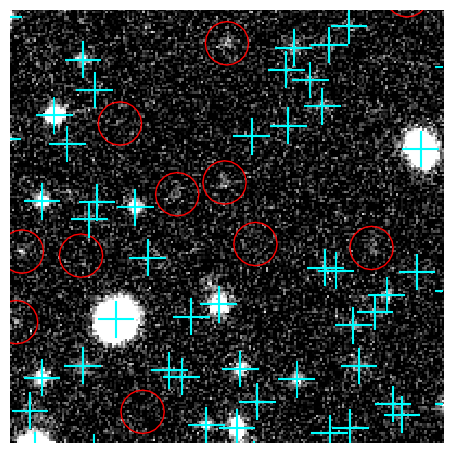

In [13]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)

display.scale('linear',min=.1,max=10,unit='Absolute')

display.mtv(cutout.image)
with display.Buffering():
    for ci in range(len(whiso)):
        display.dot('o', results['x'][whiso][ci],results['y'][whiso][ci],
                    size=10, ctype=afwDisplay.RED)
    for ci in range(len(whnot)):
        display.dot('+',results['x'][whnot][ci],results['y'][whnot][ci],
                    size=8, ctype=afwDisplay.CYAN)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()


> Figure 1: The cutout image displayed in greyscale, with cyan + marking objects that are blended in the deep_coadd, red circles marking objects that are isolated (and is not part of a blend). 

### 2.3. Identify a blend with many children

Use the TAP service to find a group of objects that were heavily blended and part of the same parent object. First, identify a set of unique `parentObjectIds`, and the number of objects that are deblended from those parentObjectIds, (stored as `counts`).  Then, select as an example a blend that was made up of 10 children. 

To identify the most blended object in the query you can replace that line with:
`most_common_index_in_unique = np.argmax(counts)`


In [14]:
unique_IDs, counts = np.unique(results['parentObjectId'], return_counts=True)

most_common_index_in_unique = np.where(counts == 15)[0]

most_common_value = unique_IDs[most_common_index_in_unique[0]] # this is what limits to only one parentId

whparent = np.where(results['parentObjectId'] == most_common_value)[0]
max_parentId = results['parentObjectId'][whparent][0]



Use TAP to retrieve all children for the selected parent.

In [15]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, parentObjectId, refExtendedness, i_blendedness_flag, " + \
        "i_cModelFlux/i_cModelFluxErr AS i_S2N, footprintArea, i_deblend_blendedness, deblend_logL, deblend_iterations, " + \
        "i_blendedness, deblend_failed, i_deblend_dataCoverage, i_deblend_zeroFlux, i_deblend_fluxOverlap, i_deblend_fluxOverlapFraction, " + \
        "deblend_incompleteData, deblend_skipped, deblend_masked, deblend_parentTooBig " + \
        "FROM dp1.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", .1)) = 1 " + \
        "AND parentObjectId = " + str(max_parentId)

print(query)

SELECT objectId, coord_ra, coord_dec, x, y, parentObjectId, refExtendedness, i_blendedness_flag, i_cModelFlux/i_cModelFluxErr AS i_S2N, footprintArea, i_deblend_blendedness, deblend_logL, deblend_iterations, i_blendedness, deblend_failed, i_deblend_dataCoverage, i_deblend_zeroFlux, i_deblend_fluxOverlap, i_deblend_fluxOverlapFraction, deblend_incompleteData, deblend_skipped, deblend_masked, deblend_parentTooBig FROM dp1.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), CIRCLE('ICRS', 53.2, -28.1, .1)) = 1 AND parentObjectId = 611254316728059699


Run the TAP query.

In [16]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Store the query results in a table called children.

In [17]:
children = job.fetch_result().to_table()
children

objectId,coord_ra,coord_dec,x,y,parentObjectId,refExtendedness,i_blendedness_flag,i_S2N,footprintArea,i_deblend_blendedness,deblend_logL,deblend_iterations,i_blendedness,deblend_failed,i_deblend_dataCoverage,i_deblend_zeroFlux,i_deblend_fluxOverlap,i_deblend_fluxOverlapFraction,deblend_incompleteData,deblend_skipped,deblend_masked,deblend_parentTooBig
,deg,deg,pix,pix,,,,,pix,,,,,,,,,,,,,
int64,float64,float64,float64,float64,int64,float32,bool,float64,int32,float32,float32,int32,float32,bool,float32,bool,float32,float32,bool,bool,bool,bool
611254316728073284,53.294864915499765,-28.126076964734423,11707.922594133186,4098.302973641447,611254316728059699,1.0,False,7.096778393068185,1127,0.0,--,0,0.0466138,False,1.0,False,0.0,0.0,False,False,False,False
611254316728073280,53.30000004299527,-28.127485719212654,11626.443568882292,4072.8016766671863,611254316728059699,0.0,False,7.809782722792145,597,0.0,--,0,0.0271333,False,1.0,False,0.0,0.0,False,False,False,False
611254316728073281,53.29739851633408,-28.127993986892044,11667.758939611198,4063.7235506255665,611254316728059699,1.0,True,-0.019130034522410754,454,0.0,--,0,--,False,1.0,False,0.0,0.0,False,False,False,False
611254316728073282,53.296165745419366,-28.128734914905575,11687.351831657825,4050.4189893817747,611254316728059699,1.0,False,7.423539277962396,1162,0.0246679,--,0,0.266039,False,1.0,False,3.46231,0.0168952,False,False,False,False
611254316728073283,53.29660129461913,-28.125536808717257,11680.340399977047,4107.979685606347,611254316728059699,1.0,False,7.419048613431707,881,0.0,--,0,0.0227583,False,1.0,False,0.0,0.0,False,False,False,False
611254316728073279,53.295658871229705,-28.125294285218384,11695.29454317496,4112.371287173421,611254316728059699,0.0,True,-0.06455831873487836,422,0.0,--,0,--,False,1.0,False,0.0,0.0,False,False,False,False
611254316728073285,53.2967491477205,-28.129172760001698,11678.103579404262,4042.5209388886897,611254316728059699,0.0,True,6.25844073372527,993,0.0102184,--,0,0.103867,False,1.0,False,38.0434,0.196383,False,False,False,False
611254316728073286,53.29294969335254,-28.12786049935853,11738.380787078966,4066.2472628100695,611254316728059699,0.0,False,5.4996531838805645,388,0.0,--,0,0.057179,False,1.0,False,0.0,0.0,False,False,False,False


The table above confirms that the children returned by the query were deblended from the same parent source, since they all show the same parentObjectId. 

Use the `cutout_coadd` function to obtain a cutout image to visualize the blend. Set the size of the cutout to be 5x the square root of the `footprintArea`.



### 2.4 Poorly deblended photometry

First, objects for which the deblender failed in some way can be identified using the `<f>_blendedness_flag`. Print the keywords for these objects to explore the reasons the deblender failed. In 2 cases, the S/N is low indicating a non-detection in i-band.

In [30]:
ra = 95.0
dec = -25.0
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "refExtendedness, detect_fromBlend, detect_isIsolated, " + \
        "parentObjectId, deblend_failed, i_deblend_fluxOverlapFraction, " + \
        "footprintArea, i_blendedness, i_deblend_blendedness, i_blendedness_flag " + \
        "FROM dp1.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 1)) = 1 " + \
        "AND deblend_failed = 1"

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

results = job.fetch_result().to_table()
results
#whfail = np.where(results['deblend_failed'] == True)[0]
#results[whfail]

Job phase is COMPLETED


objectId,coord_ra,coord_dec,x,y,tract,patch,refExtendedness,detect_fromBlend,detect_isIsolated,parentObjectId,deblend_failed,i_deblend_fluxOverlapFraction,footprintArea,i_blendedness,i_deblend_blendedness,i_blendedness_flag
,deg,deg,pix,pix,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,int64,int64,float32,bool,bool,int64,bool,float32,int32,float32,float32,bool
612929079095593207,95.39017770383904,-25.528507612111554,14224.0,24081.0,5306,84,--,False,True,0,True,--,203,--,--,True
612929079095593210,95.3696765497277,-25.526735185486494,14557.0,24113.0,5306,84,--,False,True,0,True,--,126,--,--,True
614438983438435532,95.49173379273927,-24.535343006966123,18011.0,15179.0,5526,56,--,False,True,0,True,--,126,--,--,True


In [36]:
cutout = cutout_coadd(butler, results['coord_ra'][0], results['coord_dec'][0],                      
                      band='i', datasetType='deepCoadd',
                      cutoutSideLength=2000) 

fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)

#display.scale('linear',min=.1,max=10,unit='Absolute')

display.mtv(cutout.image)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()


band.name = 'i' AND patch.region OVERLAPS POINT(95.39017770383904, -25.528507612111554)
        
bbox =  (minimum=(13224, 23081), maximum=(15223, 25080)) xy =  (14224, 24081) cutoutSize =  (2000, 2000)


ValueError: Failure from formatter 'lsst.obs.base.formatters.fitsExposure.FitsExposureFormatter' for dataset 0b62b11b-d202-48c0-afc5-c7492c286f43 (deep_coadd from https://storage.googleapis.com/butler-us-central1-dp1/DM-51372/LSSTComCam/runs/DRP/DP1/DM-51335/deep_coadd/5306/84/i/deep_coadd_5306_84_i_lsst_cells_v1_LSSTComCam_runs_DRP_DP1_DM-51335.fits?AWSAccessKeyId=GOOG1E5Z55TDYI4OC5D7EK2DCLVELD77MINPTREQTFDM2ARHBFX2F25RO5DGW&Signature=FveO%2FYUJUZdZUq9HUBpxKJt%2BF98%3D&Expires=1758311710): 
  File "src/image/ImageBaseFitsReader.cc", line 179, in ndarray::Array<T, 2, 2> lsst::afw::image::ImageBaseFitsReader::readArray(const lsst::geom::Box2I&, lsst::afw::image::ImageOrigin, bool) [with T = float]
    Subimage box (13224,23081) 2000x2000 doesn't fit in image (11800,23800) 3400x3400 in HDU 1 {0}
lsst::pex::exceptions::LengthError: 'Subimage box (13224,23081) 2000x2000 doesn't fit in image (11800,23800) 3400x3400 in HDU 1'


Second, <a href="https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract">Mandelbaum et al. 2018</a>  quantitatively explored the criteria for acceptable blendedness,  finding that remaining <f>_blendedness below 10**-0.375 (or about 42% flux contamination from neighbors) avoids spurious detections and unacceptable contamination levels (at least for weak lensing science applications).

This number probably doesn't hold up anymore, and it should be on the PSF-convolved version of blendedness. 

Below, identify which child objects are above this threshold for unacceptable blending, potentially indicating inaccurate properties due to proximity to neighbors.

In [19]:
whbad = np.where(children['i_blendedness'] > 10**(-0.375))[0]

children[whbad]


objectId,coord_ra,coord_dec,x,y,parentObjectId,refExtendedness,i_blendedness_flag,i_S2N,footprintArea,i_deblend_blendedness,deblend_logL,deblend_iterations,i_blendedness,deblend_failed,i_deblend_dataCoverage,i_deblend_zeroFlux,i_deblend_fluxOverlap,i_deblend_fluxOverlapFraction,deblend_incompleteData,deblend_skipped,deblend_masked,deblend_parentTooBig
,deg,deg,pix,pix,,,,,pix,,,,,,,,,,,,,
int64,float64,float64,float64,float64,int64,float32,bool,float64,int32,float32,float32,int32,float32,bool,float32,bool,float32,float32,bool,bool,bool,bool
611254316728073287,53.29414955777493,-28.126644370416713,11719.296237432669,4088.1078306569243,611254316728059699,1.0,False,3.561928011397123,608,0.0,--,0,0.618377,False,1.0,False,0.0,0.0,False,False,False,False


A single source is identified with unacceptable contamination level of almost 62%. While the deblender indicates that the deblended flux is uncontaminated (i_deblend_blendedness = 0) and the blendedness flag returns False, the blendedness measure can assist in quality control of photometric sources that are poorly measured after the deblending process.

Below, visualize these test cases along with the other child sources of this parentObjectId.

In [20]:
cutout = cutout_coadd(butler, children['coord_ra'][0],
                      children['coord_dec'][0],
                      band='i', datasetType='deepCoadd',
                      cutoutSideLength=2.0 * 
                      np.sqrt(np.sum(children['footprintArea']))) 


band.name = 'i' AND patch.region OVERLAPS POINT(53.294864915499765, -28.126076964734423)
        
bbox =  (minimum=(11579, 3969), maximum=(11837, 4227)) xy =  (11708, 4098) cutoutSize =  (259, 259)


Display the `deepCoadd` cutout made for this parent, with all deblended children identified with red circles. Identify the fraction of children for which the deblender flag is True (indicates that there is an issue with its photometry) with cyan circle.

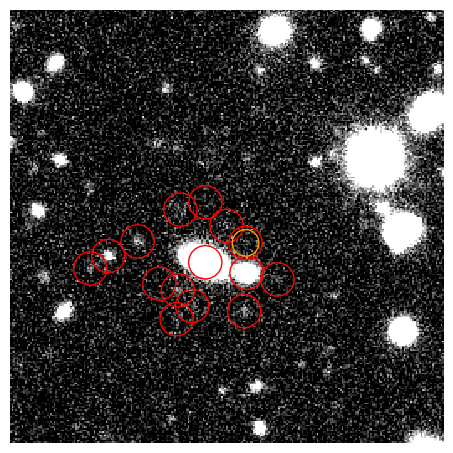

In [21]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)
display.scale('linear', min=0.1, max=10, unit='Absolute')
display.mtv(cutout.image)
with display.Buffering():
    for ci in range(len(children)):
        display.dot('o', children['x'][ci], children['y'][ci],
                    size=10, ctype=afwDisplay.RED)
    for ci in range(len(whfail)):
        display.dot('o',children['x'][whfail][ci],children['y'][whfail][ci],
                    size=8, ctype=afwDisplay.CYAN)
    for ci in range(len(whbad)):
        display.dot('o',children['x'][whbad][ci],children['y'][whbad][ci],
                    size=8, ctype=afwDisplay.ORANGE)

plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

> Figure 2: The cutout image displayed in greyscale, with red circles marking the deblended children, cyan circles indicating the children that failed to be properly deblended (i_blendedness_flag = True) and in orange the child whose contamination from neighbors is too high. 


## 4. Blend properties in ECDFS

Fred's talk at PCW 2022 https://project.lsst.org/meetings/rubin2022/sites/default/files/PCW%20Update%20on%20the%20LSST%20Deblender-2.pdf says 4.5% of galaxies have blendedness > 0.05. Perhaps show what it is in ECDFS, and compare blendedness with deblend_blendedness (but, why don't sources with 0 deblend_blendedness all have blendedness_Flag = false?)

Can you identify where scarlet is doing poorlY? sources where blends are overlapping above the noise? (more than 5% of flux is overlapping? fluxOverlapRatio) maybe 65% of sources are blended in observed frame? But in deconvolved frame which is what deblender sees, maybe only 14% of sources are overlapping, so maybe things are not so bad.



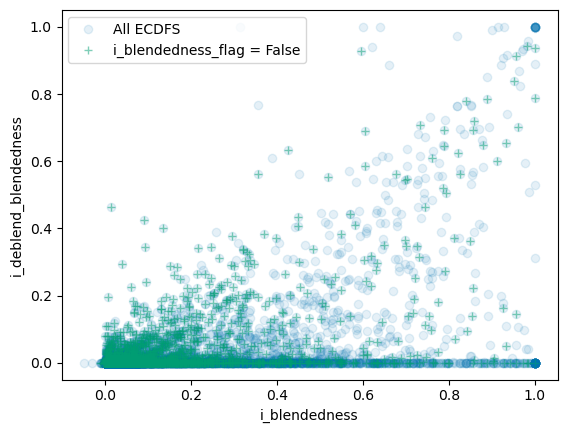

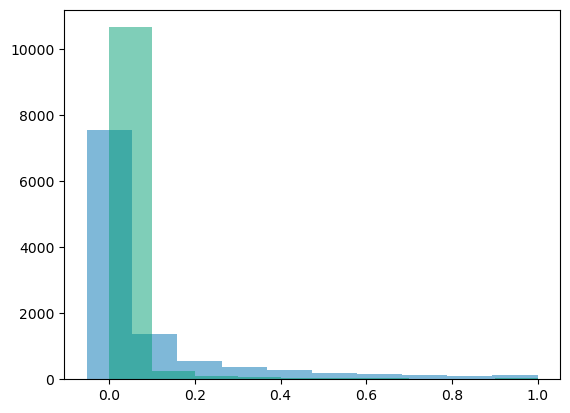

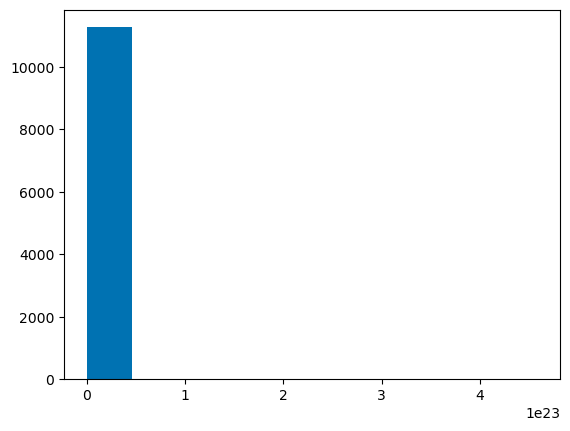

In [22]:

wh = np.where(results['i_blendedness_flag'] == False)[0]
plt.plot(results['i_blendedness'],results['i_deblend_blendedness'],'o',alpha=.1,label='All ECDFS')
plt.plot(results['i_blendedness'][wh],results['i_deblend_blendedness'][wh],'+',alpha=.5,label='i_blendedness_flag = False')
wh = np.where(results['i_deblend_blendedness'] > 0.05)[0]
#plt.plot(results['i_blendedness'][wh],results['i_deblend_blendedness'][wh],'.',alpha=.5,label='deblend_blendedness > 0.05 (5% of flux overlapping?)')
plt.legend()
plt.xlabel('i_blendedness')
plt.ylabel('i_deblend_blendedness')
plt.show()

plt.hist(results['i_blendedness'],alpha=0.5)
plt.hist(results['i_deblend_blendedness'],alpha=.5)
plt.show()

plt.hist(results['i_deblend_fluxOverlapFraction'])
plt.show()

In [23]:
import sys
sys.exit()
# junk code below

SystemExit: 

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:


#check this thing out:
#https://community.lsst.org/t/dp1-deblended-object-footprints/10715

https://pipelines.lsst.io/releases/v25_0_0.html#release-v25-0-0-scarlet-storage

Fred's talk at PCW 2022 https://project.lsst.org/meetings/rubin2022/sites/default/files/PCW%20Update%20on%20the%20LSST%20Deblender-2.pdf says 4.5% of galaxies have blendedness > 0.05. Perhaps show what it is in ECDFS, and compare blendedness with deblend_blendedness (but, why don't sources with 0 deblend_blendedness all have blendedness_Flag = false?)